In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the PINN model as a fully connected neural networ
a = torch.tensor([1.0], device="cuda")
b = torch.tensor([2.0], device="cuda")
c = a + b
print(c)
        

tensor([3.], device='cuda:0')


In [5]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Should print 'cuda' if GPU is available


True
NVIDIA T1200 Laptop GPU
Using device: cuda


Epoch 0, Loss: 0.007305
Epoch 1000, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 3000, Loss: 0.000000
Epoch 4000, Loss: 0.000000


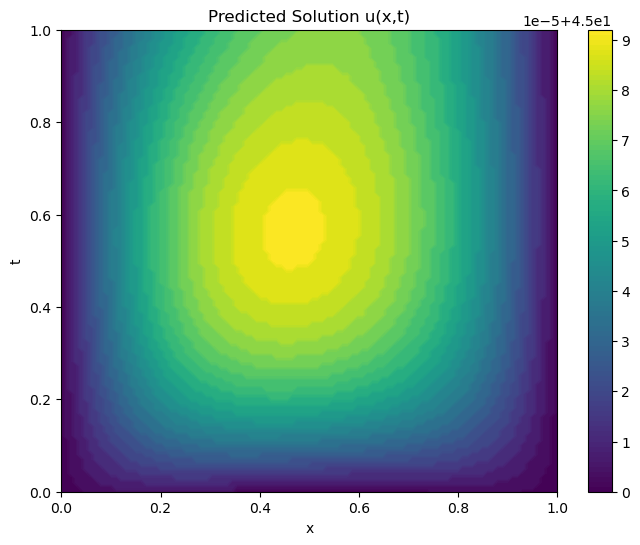

In [6]:


# Device configuration (assuming CUDA available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the PINN model (which approximates ũ(x, t))
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.layers) - 1):
            out = self.activation(self.layers[i](out))
        out = self.layers[-1](out)
        return out

# Define the trial solution which exactly satisfies the Dirichlet condition u=45 at x=0 and x=1.
def trial_solution(model, X):
    # X is a tensor with columns [x, t]
    x = X[:, 0:1]
    t = X[:, 1:2]
    # u_tilde is the output of the neural network (free part of the solution)
    u_tilde = model(torch.cat([x, t], dim=1))
    # Define φ(x, t) such that φ = 0 on the boundaries x=0 and x=1.
    # For a 1D spatial domain [0,1] we can use:
    phi = x * (1 - x)
    # g(x, t) is the function that exactly satisfies the boundary condition.
    g = 45.0  # constant boundary value
    return g + phi * u_tilde

# Generate collocation points inside the domain (for PDE residual)
def generate_collocation_points(num_points):
    x = np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, 1, num_points)
    X = np.vstack((x, t)).T  # Shape: [num_points, 2]
    return torch.tensor(X, dtype=torch.float32).to(device)

# Define the loss function based on the heat equation: u_t - u_xx = 0,
# where u is the trial solution.
def pde_loss(model, collocation_points):
    collocation_points.requires_grad = True
    x = collocation_points[:, 0:1]
    t = collocation_points[:, 1:2]
    
    # Compute the trial solution
    u = trial_solution(model, collocation_points)

    du_dX = torch.autograd.grad(
        u, 
        collocation_points,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    
    u_x = du_dX[:, 0:1]
    u_t = du_dX[:, 1:2]
    
    # Compute second derivative w.r.t. x
    du2_dX2 = torch.autograd.grad(
        u_x,
        collocation_points,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]  # Again shape: [N, 2]
    
    # du2_dX2[:, 0:1] is ∂²u/∂x²
    u_xx = du2_dX2[:, 0:1]
    
    # PDE residual: u_t - u_xx = 0
    residual = u_t - u_xx
    return torch.mean(residual**2)

# Train the PINN using only the PDE loss (boundary condition is enforced by the trial function)
def train_pinn(model, collocation_points, epochs=10000, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pde_loss(model, collocation_points)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return model

# Visualize the predicted solution on a grid using the trial solution
def plot_solution(model):
    x_vals = np.linspace(0, 1, 100)
    t_vals = np.linspace(0, 1, 100)
    X, T = np.meshgrid(x_vals, t_vals)
    X_flat = X.flatten()
    T_flat = T.flatten()
    XT = np.vstack((X_flat, T_flat)).T
    XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)
    
    # Evaluate the trial solution
    with torch.no_grad():
        u_pred = trial_solution(model, XT_tensor).cpu().numpy().reshape(X.shape)
    
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, T, u_pred, 100, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Solution u(x,t)')
    plt.show()

if __name__ == "__main__":
    # Define the network architecture: 2 inputs (x, t), three hidden layers, 1 output (ũ)
    layers = [2, 20, 20, 20, 1]
    model = PINN(layers)
    
    # Generate collocation points for the domain
    collocation_points = generate_collocation_points(10000)
    
    # Train the PINN (using only the PDE residual loss)
    trained_model = train_pinn(model, collocation_points, epochs=5000, lr=1e-3)
    
    # Visualize the solution (trial solution automatically satisfies u=45 on x=0 and x=1)
    plot_solution(trained_model)
